# CMSC320 Final Tutorial - How much of an outlier are NBA MVPs?

### Made By: Sashwat Venkatesh

In most professional sports leagues, a variety of awards are typically given to a player or players following the conclusion of the season to recognize them for their outstanding play.
These awards typically include recognition for being a league's Most Valuable Player, as well as recognition for offensive and defensive performances.

These players are typically from the best teams, and there is often controversy and discussion around whether or not a particular player was truly deserving of their award.

This final tutorial aims to answer three questions:

1. Given statistics from previous award winners, can we accurately predict the same award winner of any given season?
2. Given a set of statistics, can we predict if a hypothetical player would have won the MVP Award?
3. Are award winners typically statistical outliers based on individual statistics, or does the success of their team play a significant role in award worthiness?

Given constraints on data availability from my sources, I will be utilizing data up to the 2016-17 NBA season, and data from future seasons to present will be used as testing to validate or invalidate my guiding questions.


# Data Scraping + Cleaning:

In [1234]:
import pandas as pd
import numpy as np
import sklearn as sk
from bs4 import BeautifulSoup
from urllib.request import urlopen
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (24, 16.5)
pd.set_option('display.max_columns', None)

player_data_df = pd.read_csv('datafiles/player_data.csv')
players_df = pd.read_csv('datafiles/Players.csv')
seasons_df = pd.read_csv('datafiles/Seasons_Stats.csv')

seasons_df = seasons_df.drop('Unnamed: 0', axis=1)
players_df = players_df.rename(columns={'collage': 'college'})

In [1235]:
# Removing '*' from all players that had an all star season, and then marking their All-Star season in a separate column 
seasons_df['All Star Season'] = np.zeros(len(seasons_df), dtype=int)
for index, row in seasons_df.iterrows():
    
    if isinstance(row['Player'], str) == False:
        continue 
    if '*' in row['Player']:
        seasons_df.loc[index, 'Player'] = row['Player'][:len(row['Player'])-1]
        seasons_df.at[index, 'All Star Season'] += 1
    tmp = int(row['Year'])
    year = str(tmp-1) + "-" + str(int(row['Year']))[2:4]
    seasons_df.loc[index, 'Year'] = year
seasons_df['PPG'] = seasons_df['PTS']/seasons_df['G']

seasons_df

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,All Star Season,PPG
0,1949-50,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,NaN,0.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,3.6,3.5,NaN,NaN,NaN,NaN,NaN,NaN,144.0,516.0,0.279,NaN,NaN,NaN,144.0,516.0,0.279,0.279,170.0,241.0,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0,0,7.269841
1,1949-50,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,NaN,0.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,0.6,2.2,NaN,NaN,NaN,NaN,NaN,NaN,102.0,274.0,0.372,NaN,NaN,NaN,102.0,274.0,0.372,0.372,75.0,106.0,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0,0,5.693878
2,1949-50,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,NaN,0.259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,2.8,3.6,NaN,NaN,NaN,NaN,NaN,NaN,174.0,499.0,0.349,NaN,NaN,NaN,174.0,499.0,0.349,0.349,90.0,129.0,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0,0,6.537313
3,1949-50,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,NaN,0.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,22.0,86.0,0.256,NaN,NaN,NaN,22.0,86.0,0.256,0.256,19.0,34.0,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0,0,4.200000
4,1949-50,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,NaN,0.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,21.0,82.0,0.256,NaN,NaN,NaN,21.0,82.0,0.256,0.256,17.0,31.0,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0,0,4.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,2016-17,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,0.002,0.442,8.6,17.3,12.9,9.1,1.8,3.0,10.9,15.5,NaN,3.4,2.2,5.6,0.157,NaN,-0.2,2.3,2.1,1.8,253.0,443.0,0.571,0.0,1.0,0.000,253.0,442.0,0.572,0.571,133.0,196.0,0.679,135.0,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0,0,10.306452
24687,2016-17,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,0.006,0.247,9.2,17.0,13.2,12.2,0.7,3.3,10.2,16.5,NaN,0.5,0.6,1.0,0.094,NaN,-3.2,0.8,-2.5,-0.1,78.0,158.0,0.494,0.0,1.0,0.000,78.0,157.0,0.497,0.494,22.0,39.0,0.564,43.0,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0,0,3.490196
24688,2016-17,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,0.000,0.161,10.8,24.9,17.6,5.3,0.9,3.7,8.3,14.8,NaN,-0.1,0.1,0.0,-0.005,NaN,-7.8,0.4,-7.3,-0.1,10.0,31.0,0.323,0.0,0.0,NaN,10.0,31.0,0.323,0.323,3.0,5.0,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0,0,1.210526
24689,2016-17,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,0.448,0.181,1.9,14.2,8.0,6.1,0.9,1.5,14.4,14.4,NaN,-0.3,0.8,0.5,0.030,NaN,-3.6,-0.1,-3.7,-0.4,88.0,221.0,0.398,33.0,99.0,0.333,55.0,122.0,0.451,0.473,31.0,40.0,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0,0,5.454545


In [1236]:
# Getting the table of all NBA MVPs
url = 'https://www.basketball-reference.com/awards/mvp.html'
output = str(BeautifulSoup(urlopen(url), 'html.parser').findAll('table', id='mvp_NBA')[0])
mvpframe = pd.read_html(output)[0]

In [1237]:
# This function is used to fix the BasketballReference table and convert them into more readable and usable DataFrames
def fix_frame(frame):
    fixed = {   'Season': frame['Unnamed: 0_level_0']['Season'], 
                    'Player': frame['Unnamed: 2_level_0']['Player'],
                    'Age': frame['Unnamed: 4_level_0']['Age'],
                    'Team': frame['Unnamed: 5_level_0']['Tm'],
                    'Games Played': frame['Unnamed: 6_level_0']['G'],
                    'MPG': frame['Per Game']['MP'],
                    'PPG': frame['Per Game']['PTS'],
                    'RPG': frame['Per Game']['TRB'],
                    'APG': frame['Per Game']['AST'],
                    'SPG': frame['Per Game']['STL'],
                    'BPG': frame['Per Game']['BLK'],
                    'FG%': frame['Shooting']['FG%'],
                    '3P%': frame['Shooting']['3P%'],
                    'FT%': frame['Shooting']['FT%'],
                    'WS': frame['Advanced']['WS'],
                    'WS/48': frame['Advanced']['WS']}
    res = pd.DataFrame(data=fixed)
    return res

In [1238]:
# Showing the fixed DataFrame
mvpframe = fix_frame(mvpframe)
mvpframe


,Season,Player,Age,Team,Games Played,MPG,PPG,RPG,APG,SPG,BPG,FG%,3P%,FT%,WS,WS/48
0,2021-22,Nikola Jokić,26,DEN,74,33.5,27.1,13.8,7.9,1.5,0.9,0.583,0.337,0.810,15.2,15.2
1,2020-21,Nikola Jokić,25,DEN,72,34.6,26.4,10.8,8.3,1.3,0.7,0.566,0.388,0.868,15.6,15.6
2,2019-20,Giannis Antetokounmpo,25,MIL,63,30.4,29.5,13.6,5.6,1.0,1.0,0.553,0.304,0.633,11.1,11.1
3,2018-19,Giannis Antetokounmpo,24,MIL,72,32.8,27.7,12.5,5.9,1.3,1.5,0.578,0.256,0.729,14.4,14.4
4,2017-18,James Harden,28,HOU,72,35.4,30.4,5.4,8.8,1.8,0.7,0.449,0.367,0.858,15.4,15.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1959-60,Wilt Chamberlain,23,PHW,72,46.4,37.6,27.0,2.3,NaN,NaN,0.461,NaN,0.582,17.0,17.0
63,1958-59,Bob Pettit,26,STL,72,39.9,29.2,16.4,3.1,NaN,NaN,0.438,NaN,0.759,14.8,14.8
64,1957-58,Bill Russell,23,BOS,69,38.3,16.6,22.7,2.9,NaN,NaN,0.442,NaN,0.519,11.3,11.3
65,1956-57,Bob Cousy,28,BOS,64,36.9,20.6,4.8,7.5,NaN,NaN,0.378,NaN,0.821,8.8,8.8


In [1239]:
# Building dataframe that contains win-loss for all seasons up to 2015-16
winloss = pd.read_excel('datafiles/Historical NBA Performance.xlsx')
winloss = winloss.drop(columns=['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'])
winloss['Wins'] = np.zeros(len(winloss), dtype=int)
winloss['Losses'] = np.zeros(len(winloss), dtype=int)
for index, row in winloss.iterrows():
    wl = row['Record'].split('-')
    winloss.loc[index, 'Wins'] = wl[0]
    winloss.loc[index, 'Losses'] = wl[1]
winloss = winloss.drop(columns=['Record'])
winloss

,Year,Team,Winning Percentage,Wins,Losses
0,2016-17,Celtics,0.625,25,15
1,2015-16,Celtics,0.585,48,34
2,2014-15,Celtics,0.488,40,42
3,2013-14,Celtics,0.305,25,57
4,2012-13,Celtics,0.506,41,40
...,...,...,...,...,...
1412,1965-66,Bullets,0.475,38,42
1413,1964-65,Bullets,0.463,37,43
1414,1963-64,Bullets,0.388,31,49
1415,1962-63,Zephyrs,0.313,25,55


In [1240]:
# Creating a dataframe to convert team names from 'Celtics' -> 'BOS' for ease of function writing and data work
teams = pd.read_json('datafiles/teams.json')
teams = teams.drop(columns=['teamId'])
teams.head()

,abbreviation,teamName,simpleName,location
0,ATL,Atlanta Hawks,Hawks,Atlanta
1,BOS,Boston Celtics,Celtics,Boston
2,BKN,Brooklyn Nets,Nets,Brooklyn
3,CHA,Charlotte Hornets,Hornets,Charlotte
4,CHI,Chicago Bulls,Bulls,Chicago


In [1241]:
# Updating names in win-loss dataframe
for index, row in winloss.iterrows():
    for index2, row2 in teams.iterrows():
        if row['Team'] == row2['simpleName']:
            winloss.loc[index, 'Team'] = row2['abbreviation']
winloss

,Year,Team,Winning Percentage,Wins,Losses
0,2016-17,BOS,0.625,25,15
1,2015-16,BOS,0.585,48,34
2,2014-15,BOS,0.488,40,42
3,2013-14,BOS,0.305,25,57
4,2012-13,BOS,0.506,41,40
...,...,...,...,...,...
1412,1965-66,Bullets,0.475,38,42
1413,1964-65,Bullets,0.463,37,43
1414,1963-64,Bullets,0.388,31,49
1415,1962-63,Zephyrs,0.313,25,55


# Data Examination + Analysis:

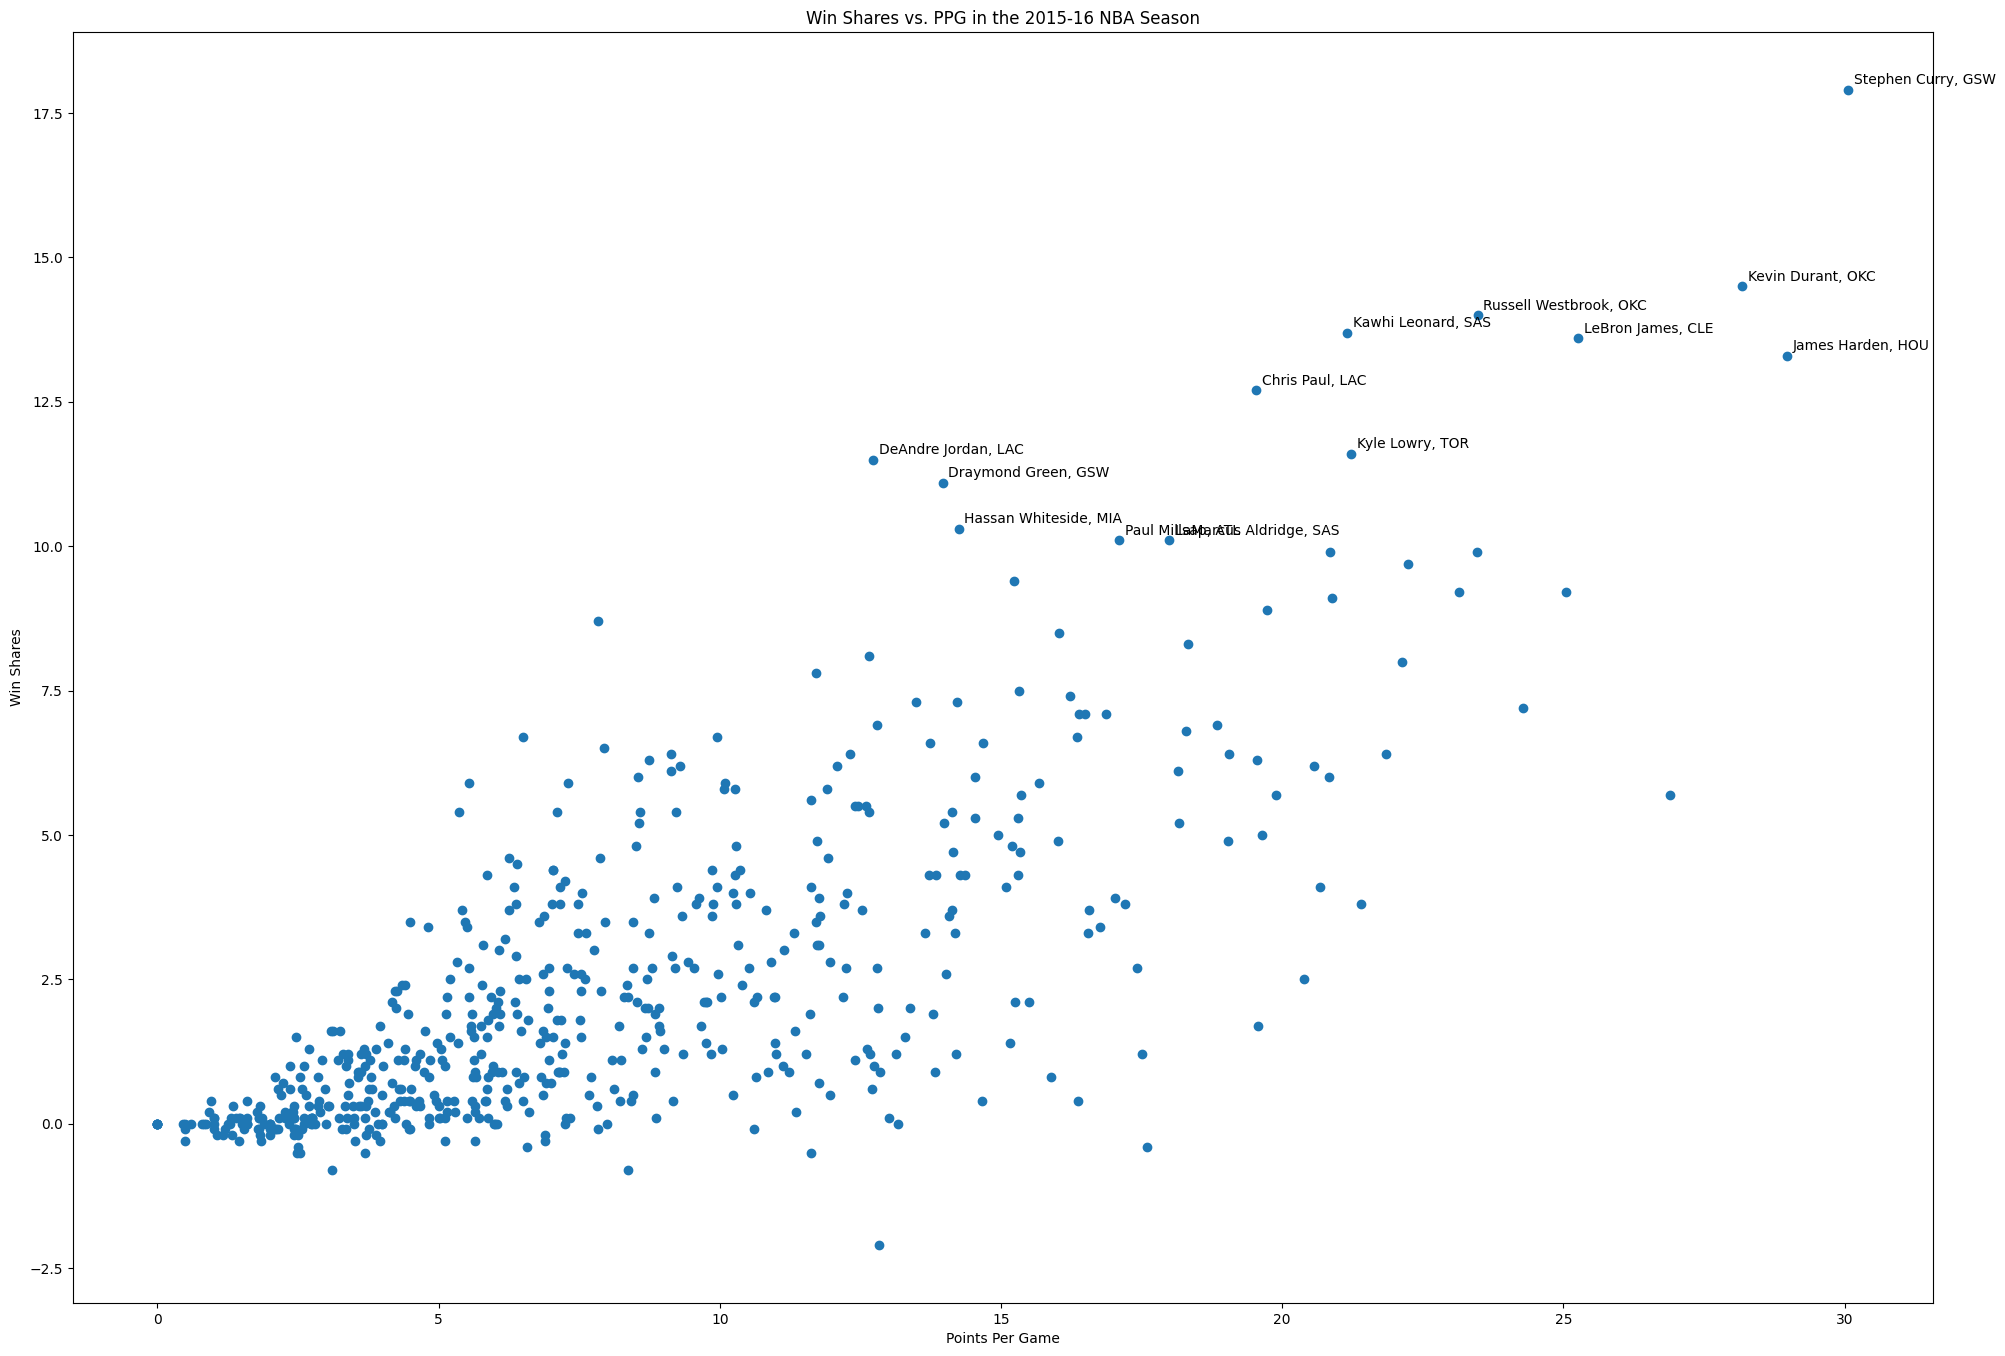

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,All Star Season,PPG
23517,2015-16,Quincy Acy,PF,25.0,SAC,59.0,29.0,876.0,14.7,0.629,0.229,0.318,8.1,15.1,11.6,4.4,1.6,2.2,10.0,13.1,NaN,1.8,0.7,2.5,0.137,NaN,0.2,0.0,0.2,0.5,119.0,214.0,0.556,19.0,49.0,0.388,100.0,165.0,0.606,0.600,50.0,68.0,0.735,65.0,123.0,188.0,27.0,29.0,24.0,27.0,103.0,307.0,0,5.203390
23518,2015-16,Jordan Adams,SG,21.0,MEM,2.0,0.0,15.0,17.3,0.427,0.167,0.833,0.0,15.9,7.6,31.9,10.3,0.0,19.6,30.5,NaN,0.0,0.0,0.0,0.015,NaN,-2.9,4.8,1.9,0.0,2.0,6.0,0.333,0.0,1.0,0.000,2.0,5.0,0.400,0.333,3.0,5.0,0.600,0.0,2.0,2.0,3.0,3.0,0.0,2.0,2.0,7.0,0,3.500000
23519,2015-16,Steven Adams,C,22.0,OKC,80.0,80.0,2014.0,15.5,0.621,0.000,0.460,12.5,16.1,14.4,4.3,1.0,3.3,14.1,12.6,NaN,4.2,2.3,6.5,0.155,NaN,0.8,1.3,2.1,2.1,261.0,426.0,0.613,0.0,0.0,NaN,261.0,426.0,0.613,0.613,114.0,196.0,0.582,219.0,314.0,533.0,62.0,42.0,89.0,84.0,223.0,636.0,0,7.950000
23520,2015-16,Arron Afflalo,SG,30.0,NYK,71.0,57.0,2371.0,10.9,0.531,0.298,0.164,1.1,11.0,6.1,9.9,0.5,0.3,8.7,17.9,NaN,1.8,0.9,2.7,0.055,NaN,-0.6,-1.8,-2.4,-0.2,354.0,799.0,0.443,91.0,238.0,0.382,263.0,561.0,0.469,0.500,110.0,131.0,0.840,23.0,243.0,266.0,144.0,25.0,10.0,82.0,142.0,909.0,0,12.802817
23521,2015-16,Alexis Ajinca,C,27.0,NOP,59.0,17.0,861.0,13.8,0.514,0.003,0.197,9.3,25.9,17.3,5.8,1.1,3.4,13.6,20.4,NaN,0.2,0.9,1.0,0.058,NaN,-4.3,-0.2,-4.5,-0.5,150.0,315.0,0.476,0.0,1.0,0.000,150.0,314.0,0.478,0.476,52.0,62.0,0.839,75.0,194.0,269.0,31.0,19.0,36.0,54.0,134.0,352.0,0,5.966102


In [1242]:
test = seasons_df[seasons_df['Year'] == '2015-16']
test2 = test[test['WS'] >= 10]
plt.scatter(test['PTS']/test['G'], test['WS'])

for index, row in test.iterrows():
    if row['WS'] >= 10:
        plt.text((row['PTS']/row['G'])+0.1, row['WS'] + 0.1, row['Player'] + ", " + row['Tm'])
plt.ylabel('Win Shares')
plt.xlabel('Points Per Game')
plt.title('Win Shares vs. PPG in the 2015-16 NBA Season')
plt.show()
test.head()

The MVP of the 2015-16 NBA Season was Steph Curry, who had the highest win shares over the course of the regular season. This provides an initial indication that the player who contributes the most win shares in the league each season may end up winning the NBA's MVP award. More information about Win Shares can be found here: https://www.basketball-reference.com/about/ws.html Let's check and see:

In [1243]:
# Given a particular stat, this function checks how many MVPs led the laege in that stat
def matches(stat):
    matches = 0
    for index, row in mvpframe.iterrows():
        if index >= 5:
            temp = seasons_df[seasons_df['Year'] == row['Season']]
            #print('Projected MVP: ' + temp[temp['WS'] == temp['WS'].max()]['Player'].max() + ", Actual MVP: " + mvpframe.loc[index, 'Player'])
            if temp[temp[stat] == temp[stat].max()]['Player'].max() == mvpframe.loc[index, 'Player']:
                matches += 1
    return (str(matches) + " matches from " + str(len(mvpframe)) + " MVPs")

In [1244]:
matches('WS')


'33 matches from 67 MVPs'

As we can see from a quick check, amongst the 67 seasons that overlap between my two datasets, 33/67, or 49.25% of MVPs were the player who had the highest Win Share stat in the league that given year. In a general sense, picking approximately 1 out of every 2 MVPs is no better than flipping a coin, so let's see if we can do any better than just the Win Share method, by using examining and combining some other key statistics.

First, let's see if guessing the top scorer, measured by Points Per Game, provides a more accurate guess:

In [1245]:
matches('PPG')

'17 matches from 67 MVPs'

PPG didn't give us a good return, at just 17/67, or just over 25% of correct matches. Let's check another stat, known as Value Over Replacement Player:

VORP is defined as: Value Over Replacement Player (available since the 1973-74 season in the NBA); a box score estimate of the points per 100 TEAM possessions that a player contributed above a replacement-level (-2.0) player, translated to an average team and prorated to an 82-game season.

Above definition from: https://www.basketball-reference.com/about/glossary.html

In [1246]:
matches('VORP')

'25 matches from 67 MVPs'

VORP gives us odds right in between PPG and WS, but still only correctly matches 37% of MVPs. Let's take a look at one more statistic, called the Player Efficiency Rating. More information on PER can be found here:(https://en.wikipedia.org/wiki/Player_efficiency_rating)

In [1247]:
matches('PER')

'13 matches from 67 MVPs'

Surprisingly, PER, an advanced stat created to combine all of a player's contributions into one number, has the worst prediction/guess rate of the 4 metrics one might easily think an MVP would lead in. However, with specific regards to PER, the use of this stat as a predictor is slightly flawed, since it is heavily impacted by the numerous rule changes that the NBA has gone through over the decades of its existence.

Now, instead of being a leader, maybe being a significant statistical outlier in these stats lends a player to being an MVP candidate. Let's examine:

In [1248]:
def grapher(stat, year):
    mvp = mvpframe[mvpframe['Season'] == year]['Player'].max()
    year_stat = seasons_df[seasons_df['Year'] == year]
    meanstat = np.mean(year_stat[stat])
    stdstat = np.std(year_stat[stat])
    standardized = [(i - meanstat)/stdstat for i in year_stat[stat]]
    mvp_stat = year_stat.loc[year_stat['Player'] == mvp]
    return ((mvp_stat[stat]-meanstat)/stdstat).max()


In [1249]:
stats = ['PPG', 'VORP', 'PER', 'WS']
mvp_dict = {}
for index, row in mvpframe.iterrows():
    if index >= 5:
        tmp = []
        for s in stats:
            tmp.append(grapher(s, row['Season']))
        mvp_dict[row['Season'] + " " + row['Player']] = tmp

Now that we have 67 MVPs worth of stats to check for outliers, let's see what we can gain from this information:

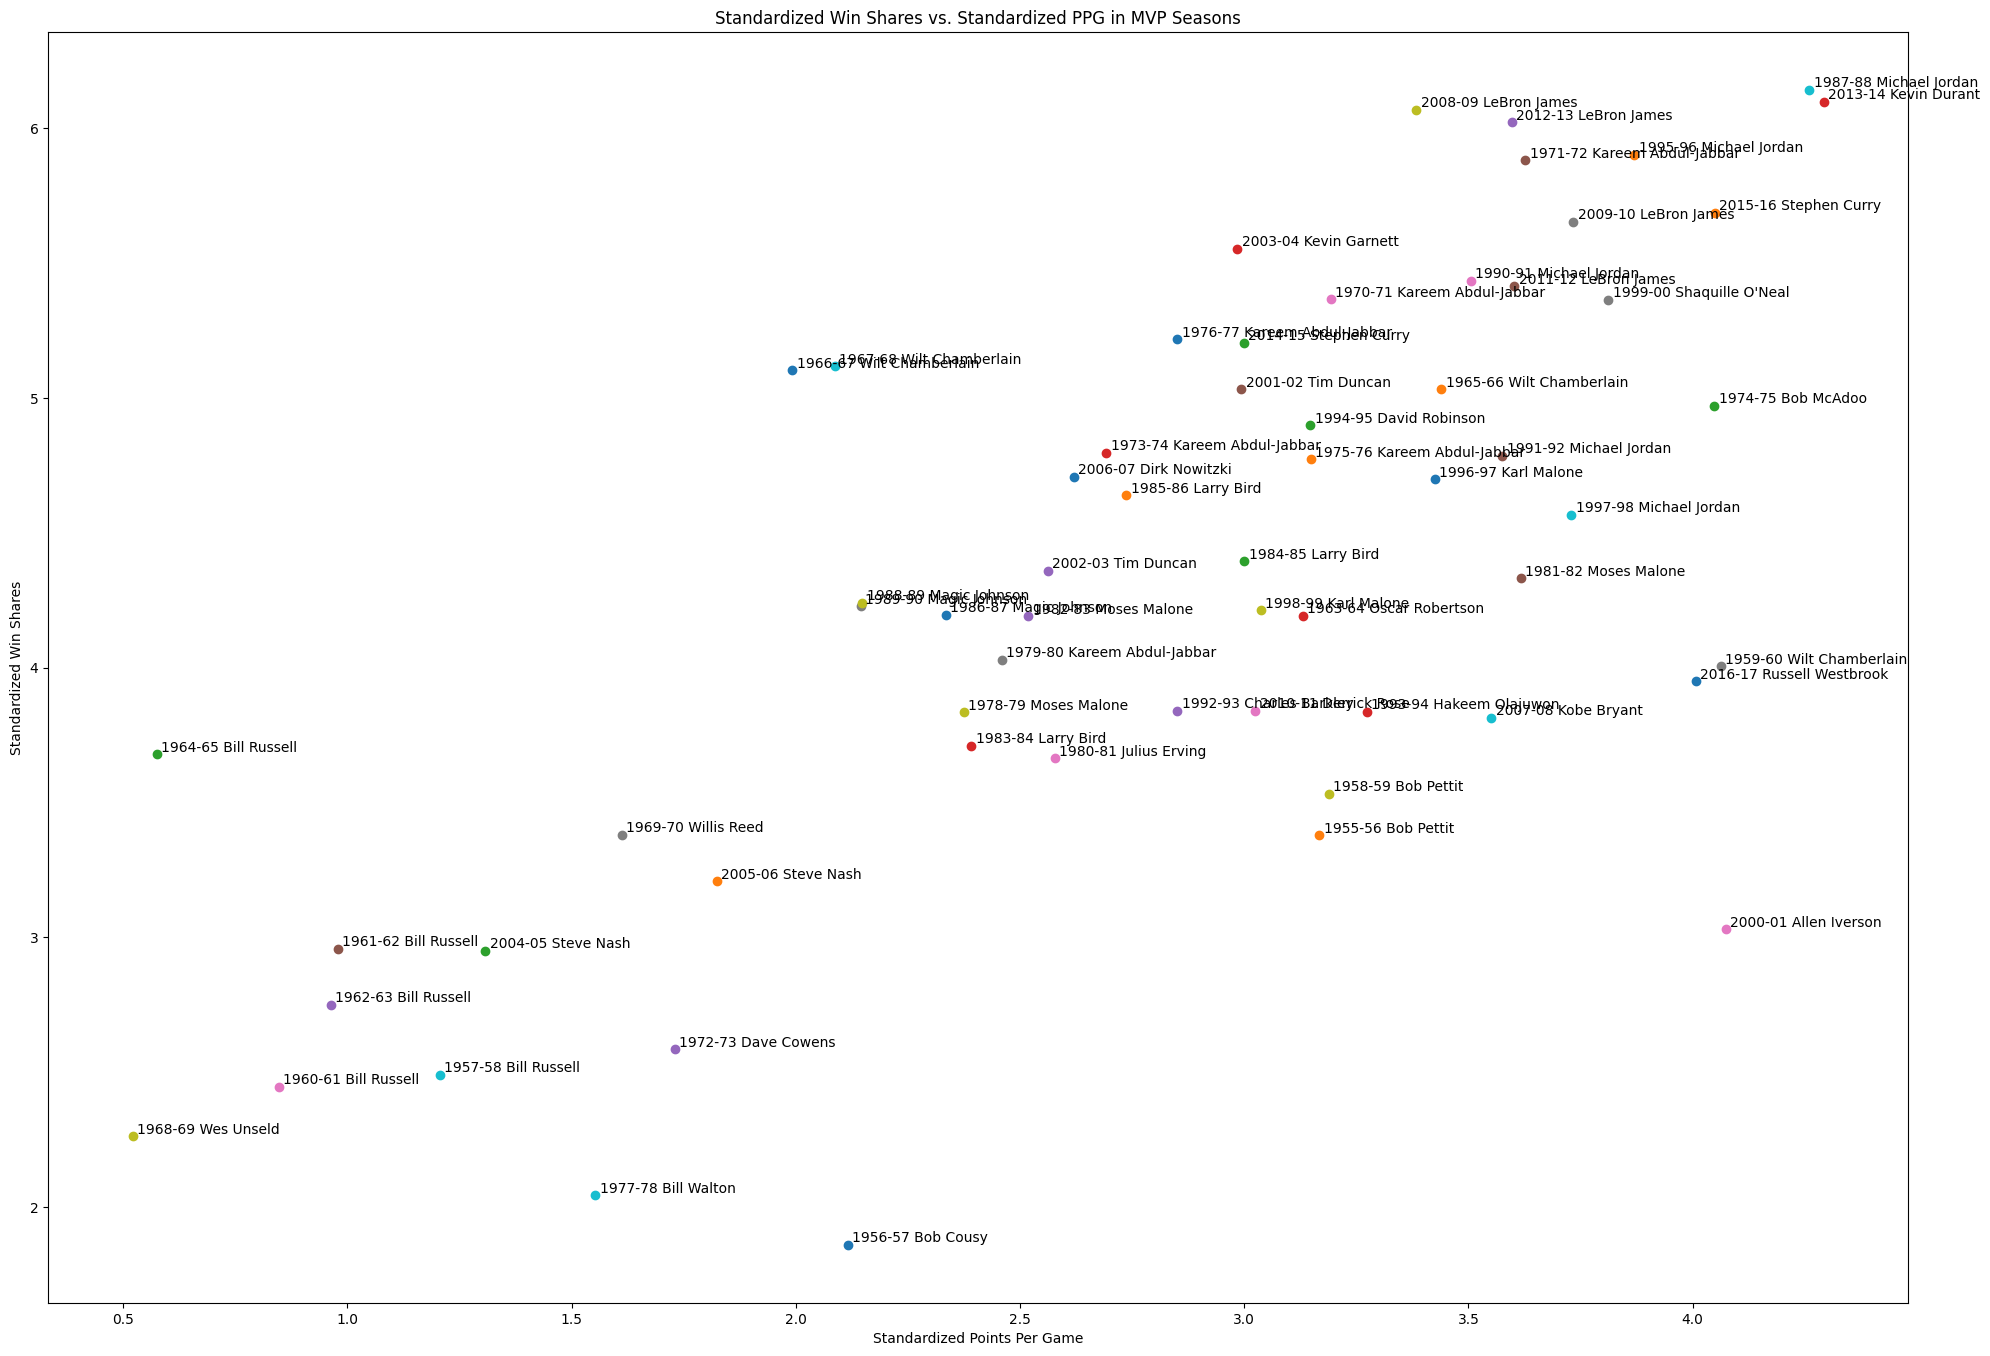

In [1250]:
# Plotting Standardized Win Shares vs. Standardized PPG to show how much of an outlier MVPs are in these two categories
ppg = []
vorp = []
per = []
ws = []
for e in mvp_dict:
    ppg.append(mvp_dict[e][0])
    vorp.append(mvp_dict[e][1])
    per.append(mvp_dict[e][2])
    ws.append(mvp_dict[e][3])
    plt.scatter(mvp_dict[e][0], mvp_dict[e][3])
    plt.text(mvp_dict[e][0]+0.01, mvp_dict[e][3]+0.01, e)

plt.title('Standardized Win Shares vs. Standardized PPG in MVP Seasons')
plt.ylabel('Standardized Win Shares')
plt.xlabel('Standardized Points Per Game')
plt.show()


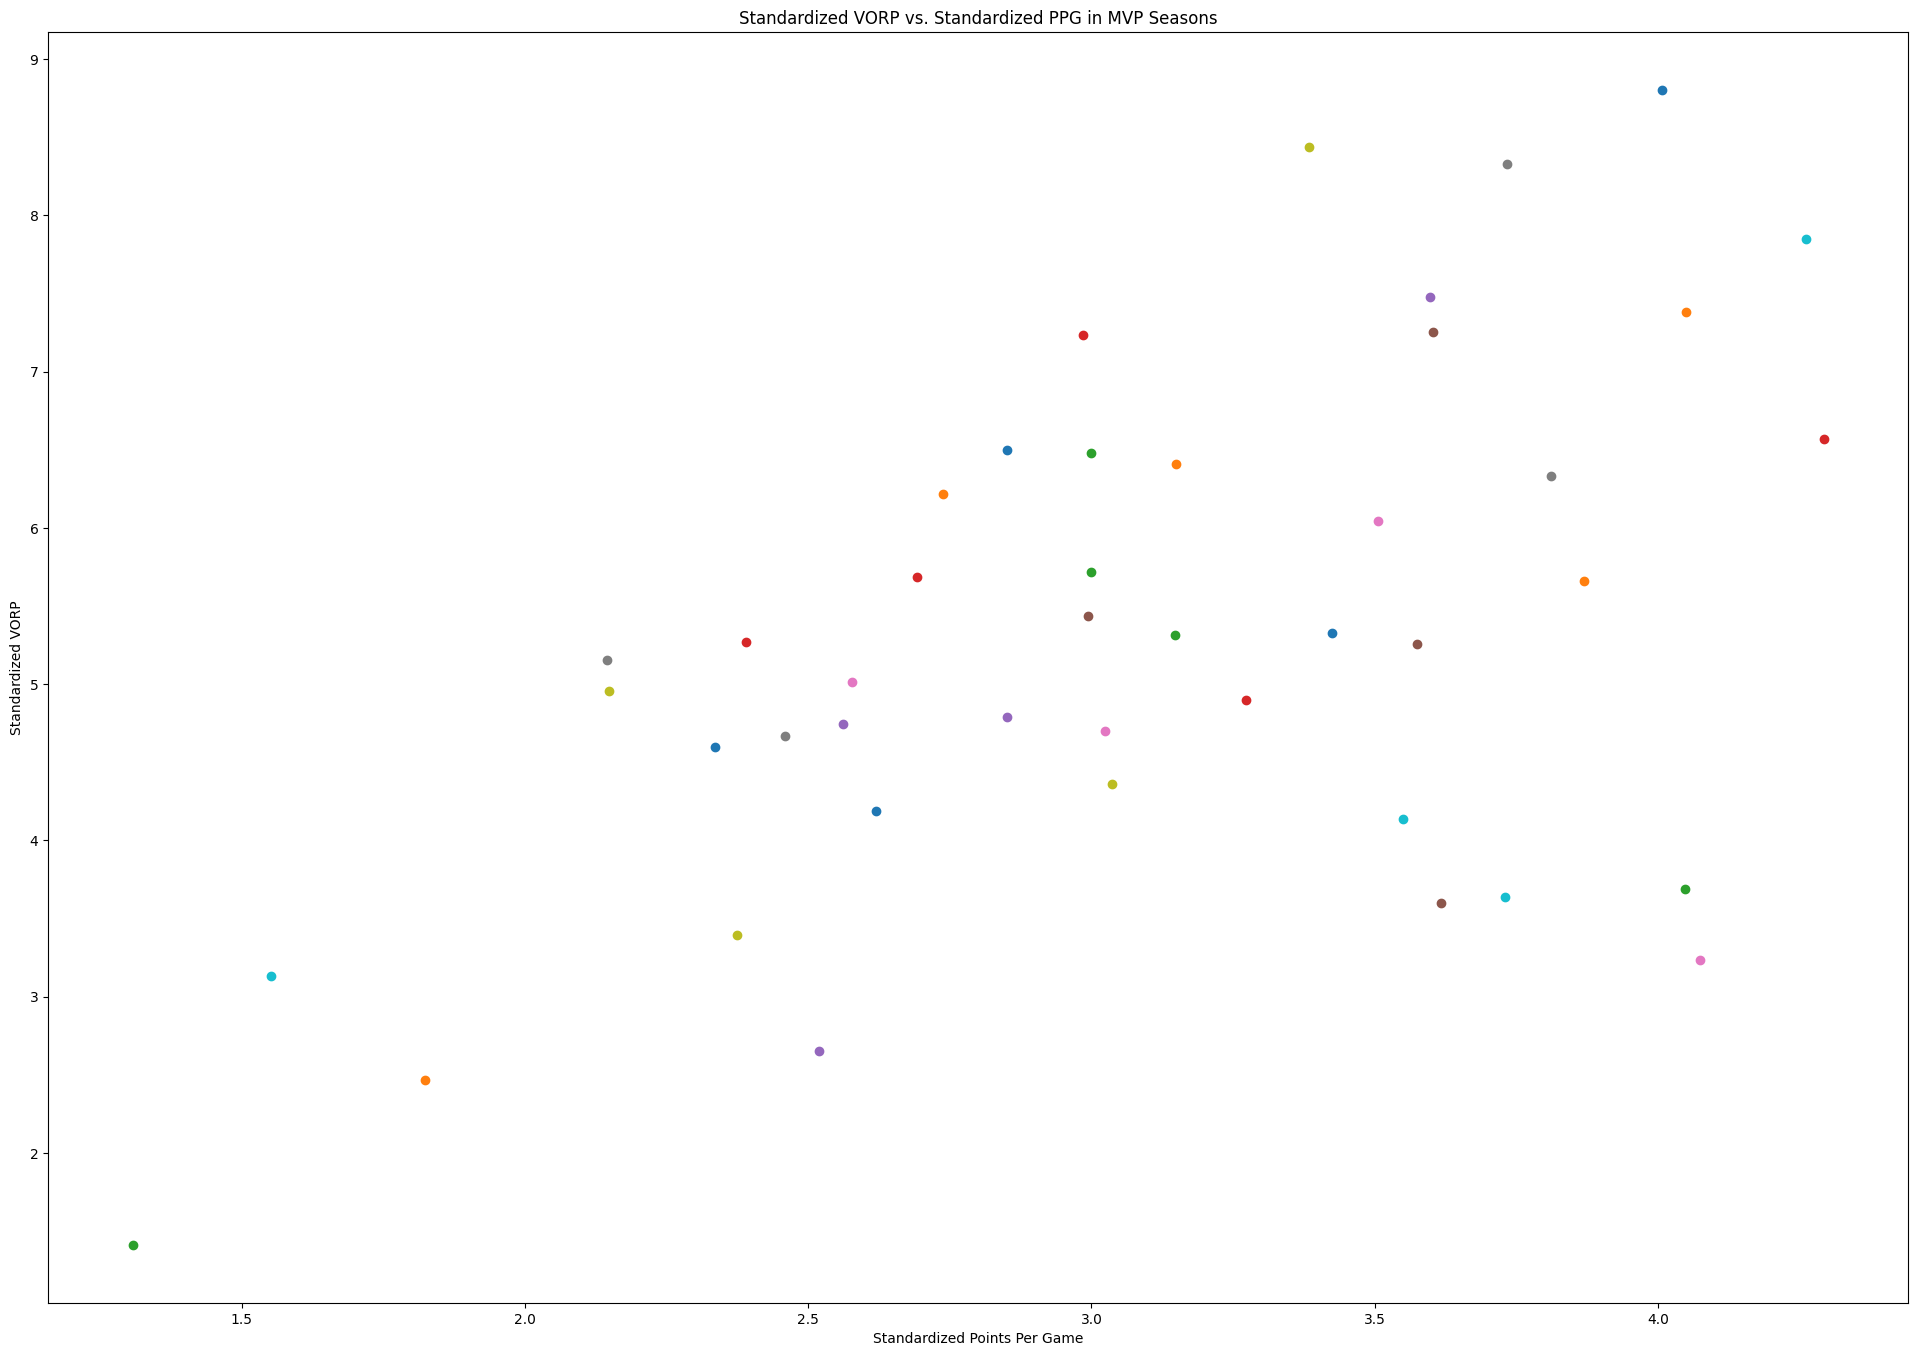

In [1251]:
# Plotting Standardized VORP vs. Standardized PPG to show how much of an outlier MVPs are in these two categories
plt.rcParams["figure.figsize"] = (24, 16.5)
for e in mvp_dict:
    plt.scatter(mvp_dict[e][0], mvp_dict[e][1])

plt.title('Standardized VORP vs. Standardized PPG in MVP Seasons')
plt.ylabel('Standardized VORP')
plt.xlabel('Standardized Points Per Game')
plt.show()

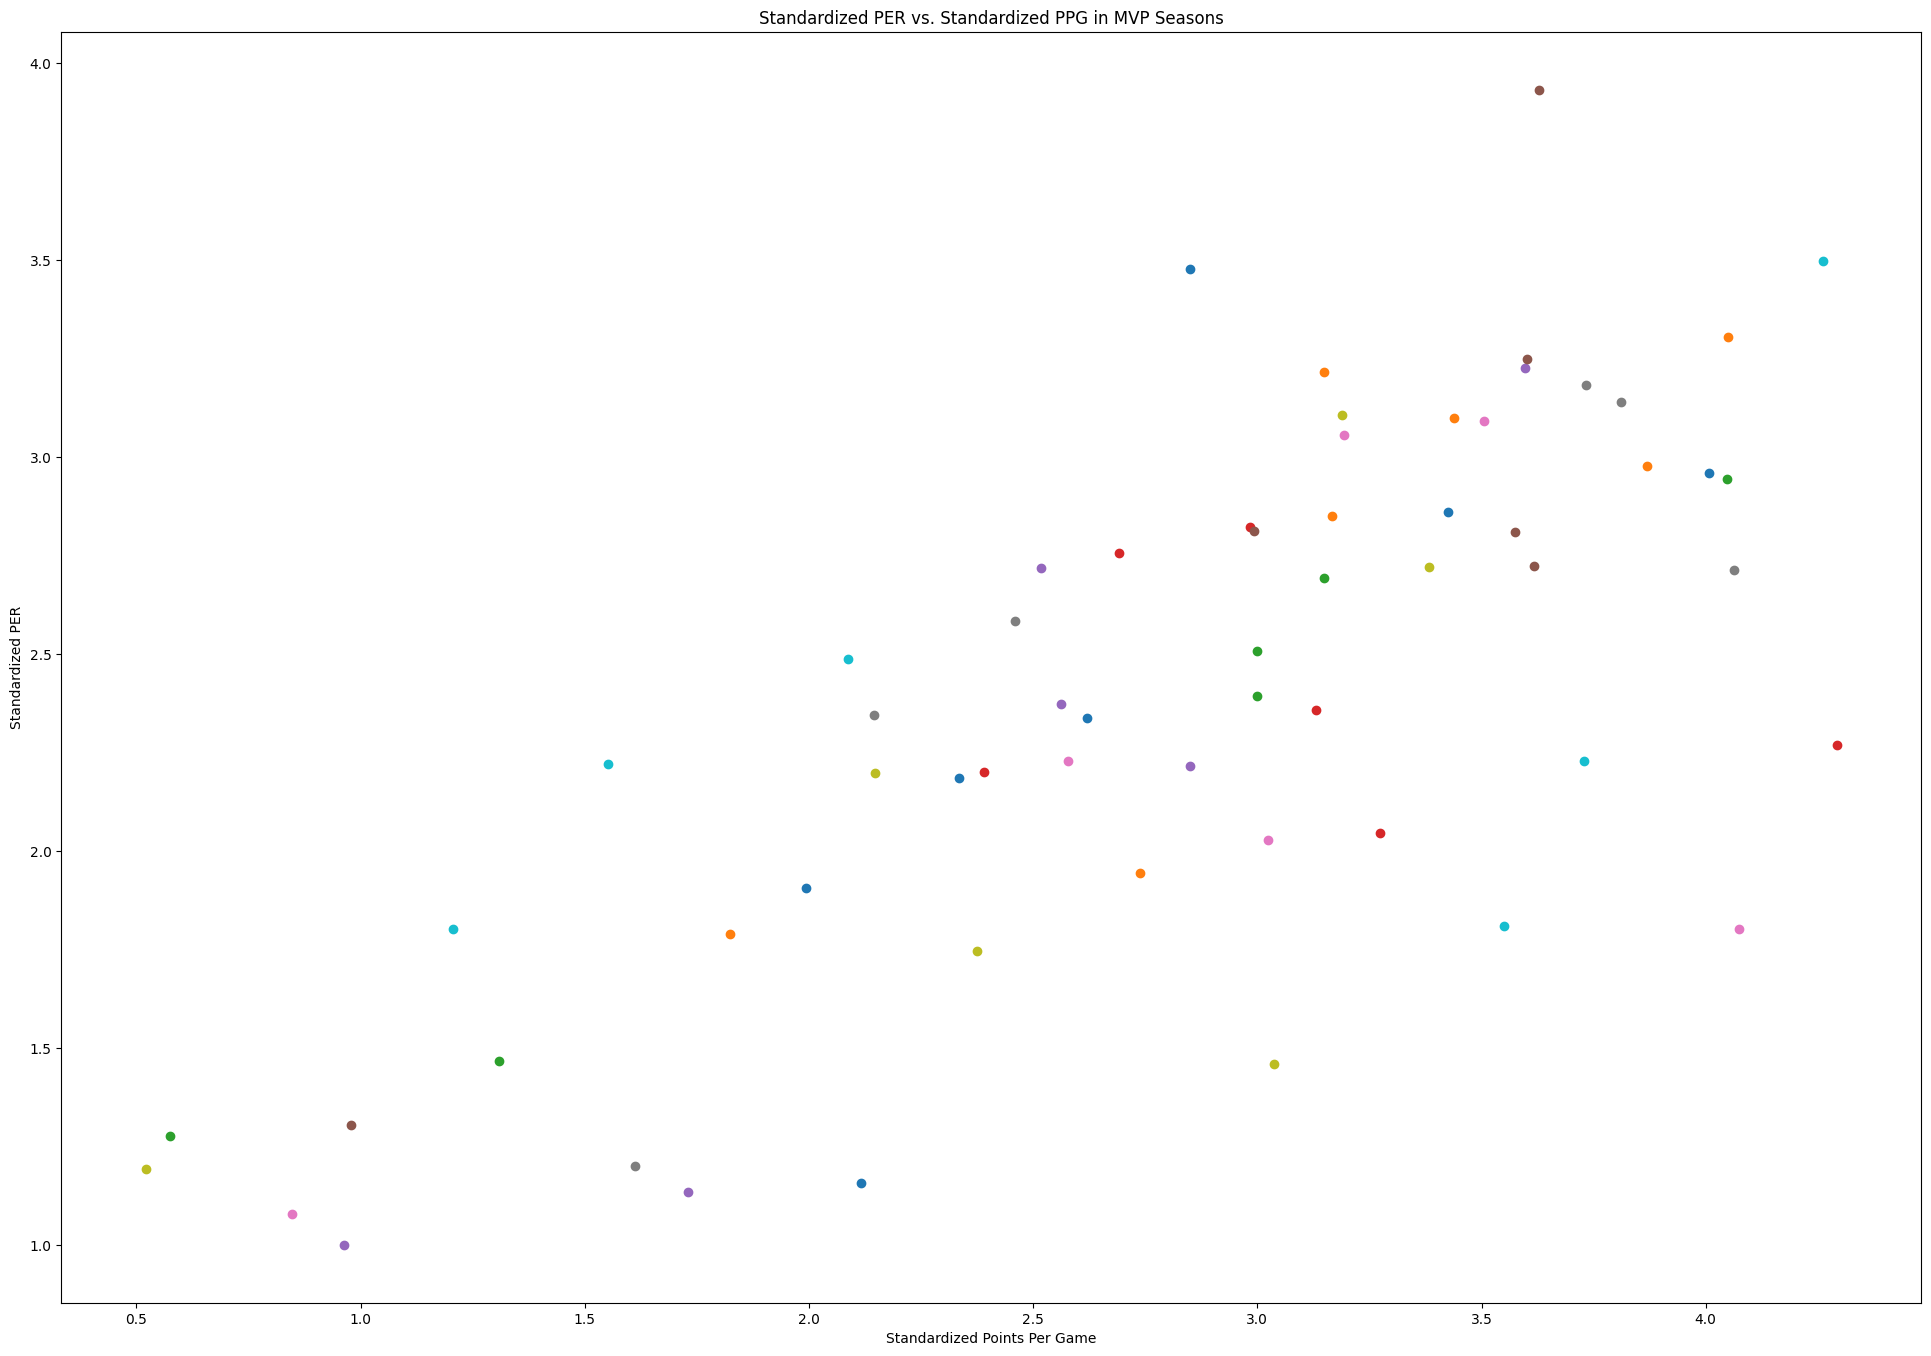

In [1252]:
# Plotting Standardized PER vs. Standardized PPG to show how much of an outlier MVPs are in these two categories
for e in mvp_dict:
    plt.scatter(mvp_dict[e][0], mvp_dict[e][2])

plt.title('Standardized PER vs. Standardized PPG in MVP Seasons')
plt.ylabel('Standardized PER')
plt.xlabel('Standardized Points Per Game')
plt.show()

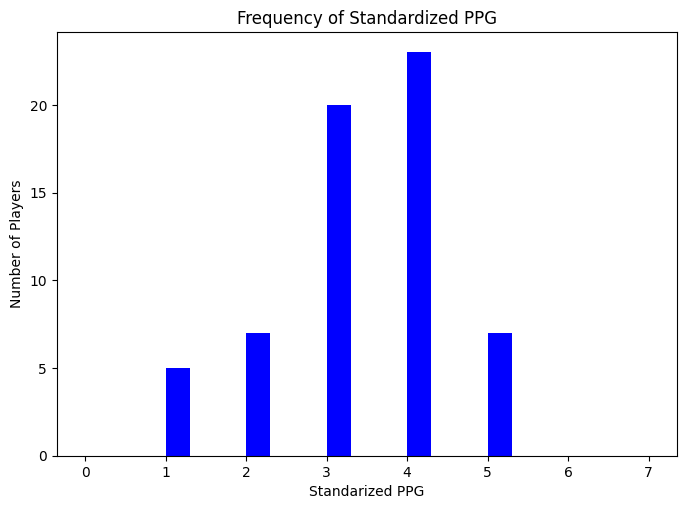

In [1253]:
plt.rcParams["figure.figsize"] = (8,5.5)
plt.hist(np.ceil(ppg), bins=np.arange(8), color='blue', width=0.3)
plt.title('Frequency of Standardized PPG')
plt.ylabel('Number of Players')
plt.xlabel('Standarized PPG')
plt.show()

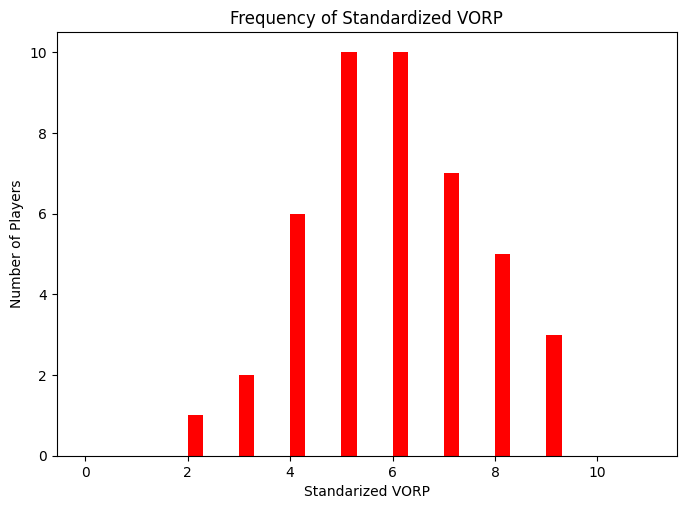

In [1254]:
plt.hist(np.ceil(vorp), bins=np.arange(12), color='red', width=0.3)
plt.title('Frequency of Standardized VORP')
plt.ylabel('Number of Players')
plt.xlabel('Standarized VORP')
plt.show()

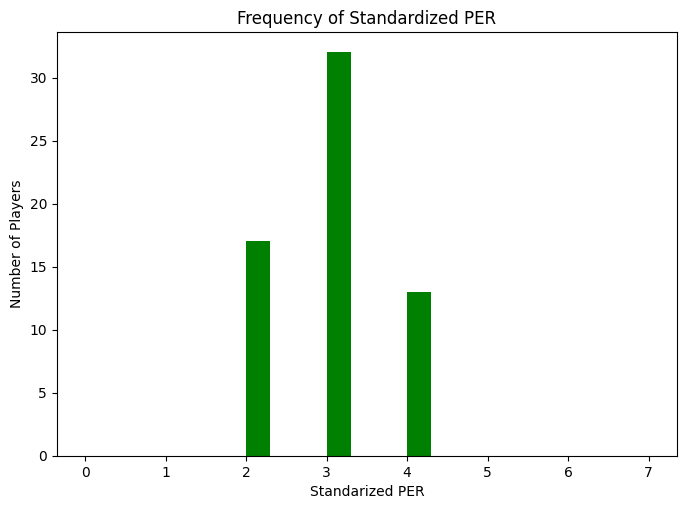

In [1255]:
plt.hist(np.ceil(per), bins=np.arange(8), color='green', width=0.3)
plt.title('Frequency of Standardized PER')
plt.ylabel('Number of Players')
plt.xlabel('Standarized PER')
plt.show()

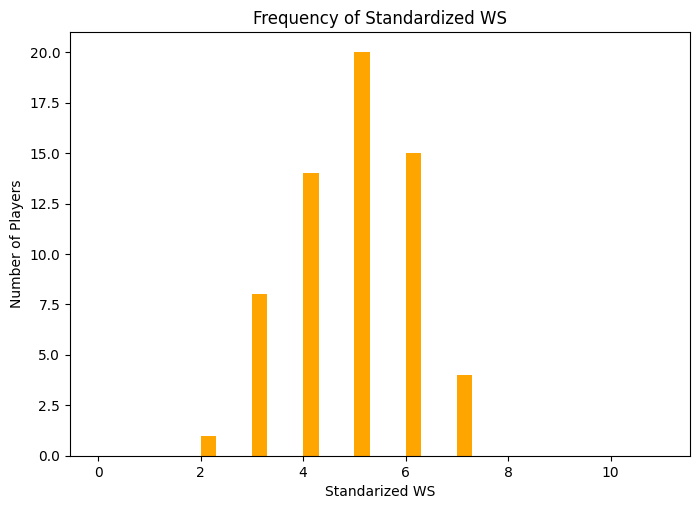

In [1256]:
plt.hist(np.ceil(ws), bins=np.arange(12), color='orange', width=0.3)
plt.title('Frequency of Standardized WS')
plt.ylabel('Number of Players')
plt.xlabel('Standarized WS')
plt.show()

Looking at the above 4 graphs, we can see that when using the ceiling function on the standardized values for PPG, VORP, PER, and WS, the following breakdown occurs:

- Most MVPs have a standardized PPG between 3 and 4.
- Most MVPs have a standardized VORP between 4 and 6.
- Most MVPs have a standardized PER between 2 and 3.
- Most MVPs have s tandardized WS between 4 and 5.

With this knowledge in mind, let's find MVPs who fit exactly in these bounds, to find the "Average MVP":

In [1257]:
averagemvp = []
for e in mvp_dict:
    if (mvp_dict[e][0] > 3 and mvp_dict[e][0] < 4) and (mvp_dict[e][1] > 4 and mvp_dict[e][1] < 6) and (mvp_dict[e][2] > 2 and mvp_dict[e][2] < 3) and (mvp_dict[e][3] > 4 and mvp_dict[e][3] < 5):
        averagemvp.append(e)
averagemvp

['1996-97 Karl Malone', '1994-95 David Robinson', '1991-92 Michael Jordan']

Now, let's check which seasons were outliers, even amongst MVPs:

In [1258]:
outliermvp = []
for e in mvp_dict:
    if (mvp_dict[e][0] > 4) and (mvp_dict[e][1] > 6) and (mvp_dict[e][2] > 3) and (mvp_dict[e][3] > 5):
        outliermvp.append(e)
outliermvp

['2015-16 Stephen Curry', '1987-88 Michael Jordan']

Based on the above observations, we can see that the 3 most "average" MVP years were:

- Karl Malone in 1996-97
- David Robinson in 1994-95
- Michael Jordan in 1991-92

From the same observations, we can see that the 2 most outlier-y MVP years were:
- Stephen Curry in 2015-16
- Michael Jordan in 1987-88

Notably, Stephen Curry won the 2015-16 NBA MVP award with a unanimous vote, the first and so far only time this has occurred in league history.

Additionally, of the 5 above seasons, only 1 of these players won the NBA championship, that player being 1991-92 Michael Jordan.

Now, we can start to develop a system for predicting MVPs. Knowing where MVPs fall, we can begin to compile a list of players from each season that could have won the MVP award, based on the following methodology.

Contending players must meet all of the following criteria:
- A ceiling standardized PPG value of at least 1
- A ceiling standardized VORP value of at least 2
- A ceiling standarized PER value of at least 2
- A ceiling standarized WS value of at least 2

In the following order, we can assign decreasing weights to these metrics to predict MVP odds:
1. Win shares (40%)
2. Value Over Replacement Player (30%)
3. Points Per Game(20%)
4. Player Efficiency Rating (10%)

In [1259]:
seasons_df['S_PPG'] = [0] * len(seasons_df)
seasons_df['S_VORP'] = [0] * len(seasons_df)
seasons_df['S_PER'] = [0] * len(seasons_df)
seasons_df['S_WS'] = [0] * len(seasons_df)


In [1260]:
def candidates(year):
    tmp = seasons_df[seasons_df['Year'] == year]

    ppgmean = np.mean(tmp['PPG'])
    ppgstd = np.std(tmp['PPG'])

    vorpmean = np.mean(tmp['VORP'])
    vorpstd = np.std(tmp['VORP'])

    permean = np.mean(tmp['PER'])
    perstd = np.std(tmp['PER'])

    wsmean = np.mean(tmp['WS'])
    wsstd = np.std(tmp['WS'])

    c = []

    for index, row in tmp.iterrows():
        tmp.at[index, 'S_PPG'] = (row['PPG'] - ppgmean)/ppgstd
        tmp.at[index, 'S_VORP'] = (row['VORP'] - vorpmean)/vorpstd
        tmp.at[index, 'S_PER'] = (row['PER'] - permean)/perstd
        tmp.at[index, 'S_WS'] = (row['WS']-wsmean)/wsstd

    for index, row in tmp.iterrows():
        if row['S_PPG'] >= 1 and row['S_VORP'] >= 2 and row['S_PER'] >= 2 and row['S_WS'] >= 2 and row['G'] >= 41:
            c.append(row['Player'])

    # convert to set to eliminate duplicates
    return tmp, list(set(c))

In [1261]:
c_dict = {}
for index, row in mvpframe.iterrows():
    if index >= 5:
        c_dict[row['Season']] = candidates(row['Season'])[1]



In [1262]:
def proj_mvp(year):
    tmp = candidates(year)[0]
    tmp['MVP'] = np.zeros(len(tmp))
    for index, row in tmp.iterrows():
        if row['S_PPG'] >= 1 and row['S_VORP'] >= 2 and row['S_PER'] >= 2 and row['S_WS'] >= 2 and row['G'] >= 41:
            tmp.at[index, 'MVP'] = (row['S_WS'] * 0.4) + (row['S_VORP'] * 0.3) + (row['S_PPG'] * 0.2) + (row['S_PER'] * 0.1)
    return list(zip(tmp['Player'], tmp['MVP']))


In [1263]:
matches = 0
for index, row in mvpframe.iterrows():
    if index >= 5:
        mvp = mvpframe[mvpframe['Season'] == row['Season']]['Player'].max()
        l = proj_mvp(row['Season'])
        l = sorted(l, key = lambda x: x[1])
        if mvp == l[len(l)-1][0]:
            matches += 1
matches

25

Utilizing my designed method, I was able to correct predict the MVP in just 25 cases. However, if I expand the check to look at the top 3 players with my designed MVP stat, this number increases to 35. This isn't much better than just blanket-using WS to predict the winner of the MVP award. This leads me to believe that team success may also play a significant factor in winning the MVP award.

In [1264]:
teams_wins = {'ATL': {2000:28, 2001:25, 2002:33, 2003:35, 2004:28, 2005:13, 2006:26, 2007:30, 2008:37, 2009:47, 2010:53, 2011:44, 2012:40, 2013:44, 2014:38, 2015:60, 2016:48, 2017:43},
             'BOS': {2000:35, 2001:36, 2002:49, 2003:44, 2004:36, 2005:45, 2006:33, 2007:24, 2008:66, 2009:62, 2010:50, 2011:56, 2012:39, 2013:41, 2014:25, 2015:40, 2016:48, 2017:53},
             'BRK': {2013:49, 2014:44, 2015:38, 2016:21, 2017:20},
              'CHA': {2005:18, 2006:26, 2007:33, 2008:32, 2009:35, 2010:44, 2011:34, 2012:7, 2013:21, 2014:43},
             'NJN': {2000:31, 2001:26, 2002:52, 2003:49, 2004:47, 2005:42, 2006:49, 2007:41, 2008:34, 2009:34, 2010:12, 2011:24, 2012:22},
             'CHH': {2000:49, 2001:46, 2002:44},
             'CHI': {2000:17, 2001:15, 2002:21, 2003:30, 2004:23, 2005:47, 2006:41, 2007:49, 2008:33, 2009:41, 2010:41, 2011:62, 2012:50, 2013:45, 2014:48, 2015:50, 2016:42, 2017:41},
             'CHO': {2015:33, 2016:48, 2017:36},
             'CLE': {2000:32, 2001:30, 2002:29, 2003:17, 2004:35, 2005:42, 2006:50, 2007:50, 2008:45, 2009:66, 2010:61, 2011:19, 2012:21, 2013:24, 2014:33, 2015:53, 2016:57, 2017:51},
             'DAL': {2000:40, 2001:53, 2002:57, 2003:60, 2004:52, 2005:58, 2006:60, 2007:67, 2008:51, 2009:50, 2010:55, 2011:57, 2012:36, 2013:41, 2014:49, 2015:50, 2016:42, 2017:33},
             'DEN': {2000:35, 2001:40, 2002:27, 2003:17, 2004:43, 2005:49, 2006:44, 2007:45, 2008:50, 2009:54, 2010:53, 2011:50, 2012:38, 2013:57, 2014:36, 2015:30, 2016:33, 2017:40},
             'DET': {2000:42, 2001:32, 2002:50, 2003:50, 2004:54, 2005:54, 2006:64, 2007:53, 2008:59, 2009:39, 2010:27, 2011:30, 2012:25, 2013:29, 2014:29, 2015:32, 2016:44, 2017:37},
             'GSW': {2000:19, 2001:17, 2002:21, 2003:38, 2004:37, 2005:34, 2006:34, 2007:42, 2008:48, 2009:29, 2010:26, 2011:36, 2012:23, 2013:47, 2014:51, 2015:67, 2016:73, 2017:67},
             'HOU': {2000:34, 2001:45, 2002:28, 2003:43, 2004:45, 2005:51, 2006:34, 2007:52, 2008:55, 2009:53, 2010:42, 2011:43, 2012:34, 2013:45, 2014:54, 2015:56, 2016:41, 2017:55},
             'IND': {2000:56, 2001:41, 2002:42, 2003:48, 2004:61, 2005:44, 2006:41, 2007:35, 2008:36, 2009:36, 2010:32, 2011:37, 2012:42, 2013:49, 2014:56, 2015:38, 2016:45, 2017:42},
             'LAC': {2000:15, 2001:31, 2002:39, 2003:27, 2004:28, 2005:37, 2006:47, 2007:40, 2008:23, 2009:19, 2010:29, 2011:32, 2012:40, 2013:56, 2014:57, 2015:56, 2016:53, 2017:51},
             'LAL': {2000:67, 2001:56, 2002:58, 2003:50, 2004:56, 2005:34, 2006:45, 2007:42, 2008:57, 2009:65, 2010:57, 2011:57, 2012:41, 2013:45, 2014:27, 2015:21, 2016:17, 2017:26},
             'MEM': {2002:23, 2003:28, 2004:50, 2005:45, 2006:49, 2007:22, 2008:22, 2009:24, 2010:40, 2011:46, 2012:41, 2013:56, 2014:50, 2015:55, 2016:42, 2017:43},
             'VAN': {2000:22, 2001:23},
              'MIA': {2000:52, 2001:50, 2002:36, 2003:25, 2004:42, 2005:59, 2006:52, 2007:44, 2008:15, 2009:43, 2010:47, 2011:58, 2012:46, 2013:66, 2014:54, 2015:37, 2016:48, 2017:41},
             'MIL': {2000:42, 2001:52, 2002:41, 2003:42, 2004:41, 2005:30, 2006:40, 2007:28, 2008:26, 2009:34, 2010:46, 2011:35, 2012:31, 2013:38, 2014:15, 2015:41, 2016:33, 2017:42},
             'MIN': {2000:50, 2001:47, 2002:50, 2003:51, 2004:58, 2005:44, 2006:33, 2007:32, 2008:22, 2009:24, 2010:15, 2011:17, 2012:26, 2013:31, 2014:40, 2015:16, 2016:29, 2017:31},
             'NOH': {2003:47, 2004:41, 2005:18, 2008:56, 2009:49, 2010:37, 2011:46, 2012:21, 2013:27},
             'NOK': {2006:38, 2007:39},
             'NOP': {2014:34, 2015:45, 2016:30, 2017:34},
             'NYK': {2000:50, 2001:48, 2002:30, 2003:37, 2004:39, 2005:33, 2006:23, 2007:33, 2008:23, 2009:32, 2010:29, 2011:42, 2012:36, 2013:54, 2014:37, 2015:17, 2016:32, 2017:31},
             'OKC': {2009:23, 2010:50, 2011:55, 2012:47, 2013:60, 2014:59, 2015:45, 2016:55, 2017:47},
             'ORL': {2000:41, 2001:43, 2002:44, 2003:42, 2004:21, 2005:36, 2006:36, 2007:40, 2008:52, 2009:59, 2010:59, 2011:52, 2012:37, 2013:20, 2014:23, 2015:25, 2016:35, 2017:29},
             'PHI': {2000:49, 2001:56, 2002:43, 2003:48, 2004:33, 2005:43, 2006:38, 2007:35, 2008:40, 2009:41, 2010:27, 2011:41, 2012:35, 2013:34, 2014:19, 2015:18, 2016:10, 2017:28},
             'PHO': {2000:53, 2001:51, 2002:36, 2003:44, 2004:29, 2005:62, 2006:54, 2007:61, 2008:55, 2009:46, 2010:54, 2011:40, 2012:33, 2013:25, 2014:48, 2015:39, 2016:23, 2017:24},
             'POR': {2000:59, 2001:50, 2002:49, 2003:50, 2004:41, 2005:27, 2006:21, 2007:32, 2008:41, 2009:54, 2010:50, 2011:48, 2012:28, 2013:33, 2014:54, 2015:51, 2016:44, 2017:41},
             'SAC': {2000:44, 2001:55, 2002:61, 2003:59, 2004:55, 2005:50, 2006:44, 2007:33, 2008:38, 2009:17, 2010:25, 2011:24, 2012:22, 2013:28, 2014:28, 2015:29, 2016:33, 2017:32},
             'SAS': {2000:53, 2001:58, 2002:58, 2003:60, 2004:57, 2005:59, 2006:63, 2007:58, 2008:56, 2009:54, 2010:50, 2011:61, 2012:50, 2013:58, 2014:62, 2015:55, 2016:67, 2017:61},
             'SEA': {2000:45, 2001:44, 2002:45, 2003:40, 2004:37, 2005:52, 2006:35, 2007:31, 2008:20},
             'TOR': {2000:45, 2001:47, 2002:42, 2003:24, 2004:33, 2005:33, 2006:27, 2007:47, 2008:41, 2009:33, 2010:40, 2011:22, 2012:23, 2013:34, 2014:48, 2015:49, 2016:56, 2017:51},
             'UTA': {2000:55, 2001:53, 2002:44, 2003:47, 2004:42, 2005:26, 2006:41, 2007:51, 2008:54, 2009:48, 2010:53, 2011:39, 2012:36, 2013:43, 2014:25, 2015:38, 2016:40, 2017:51},
             'WAS': {2000:29, 2001:19, 2002:37, 2003:37, 2004:25, 2005:45, 2006:42, 2007:41, 2008:43, 2009:19, 2010:26, 2011:23, 2012:20, 2013:29, 2014:44, 2015:46, 2016:41, 2017:49}}
# The information in this cell was taken from https://www.kaggle.com/code/fran77/predict-mvps, a similar project to mine, but with a different approach. It was modified from the original dictionary.

In [1265]:
seasons_df['Wins'] = np.zeros(len(seasons_df))
for i, row in seasons_df.iterrows():
    for k, v in teams_wins.items():
        for year, value in v.items():
            tmp = year-1
            if ((row['Tm'] == k) and (str(row['Year'])[0:4] == str(tmp))):
                seasons_df.loc[i, 'Wins'] = value
seasons_df

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,All Star Season,PPG,S_PPG,S_VORP,S_PER,S_WS,Wins
0,1949-50,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,NaN,0.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,3.6,3.5,NaN,NaN,NaN,NaN,NaN,NaN,144.0,516.0,0.279,NaN,NaN,NaN,144.0,516.0,0.279,0.279,170.0,241.0,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0,0,7.269841,0,0,0,0,0.0
1,1949-50,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,NaN,0.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,0.6,2.2,NaN,NaN,NaN,NaN,NaN,NaN,102.0,274.0,0.372,NaN,NaN,NaN,102.0,274.0,0.372,0.372,75.0,106.0,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0,0,5.693878,0,0,0,0,0.0
2,1949-50,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,NaN,0.259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,2.8,3.6,NaN,NaN,NaN,NaN,NaN,NaN,174.0,499.0,0.349,NaN,NaN,NaN,174.0,499.0,0.349,0.349,90.0,129.0,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0,0,6.537313,0,0,0,0,0.0
3,1949-50,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,NaN,0.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,22.0,86.0,0.256,NaN,NaN,NaN,22.0,86.0,0.256,0.256,19.0,34.0,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0,0,4.200000,0,0,0,0,0.0
4,1949-50,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,NaN,0.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,21.0,82.0,0.256,NaN,NaN,NaN,21.0,82.0,0.256,0.256,17.0,31.0,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0,0,4.538462,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,2016-17,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,0.002,0.442,8.6,17.3,12.9,9.1,1.8,3.0,10.9,15.5,NaN,3.4,2.2,5.6,0.157,NaN,-0.2,2.3,2.1,1.8,253.0,443.0,0.571,0.0,1.0,0.000,253.0,442.0,0.572,0.571,133.0,196.0,0.679,135.0,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0,0,10.306452,0,0,0,0,36.0
24687,2016-17,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,0.006,0.247,9.2,17.0,13.2,12.2,0.7,3.3,10.2,16.5,NaN,0.5,0.6,1.0,0.094,NaN,-3.2,0.8,-2.5,-0.1,78.0,158.0,0.494,0.0,1.0,0.000,78.0,157.0,0.497,0.494,22.0,39.0,0.564,43.0,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0,0,3.490196,0,0,0,0,53.0
24688,2016-17,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,0.000,0.161,10.8,24.9,17.6,5.3,0.9,3.7,8.3,14.8,NaN,-0.1,0.1,0.0,-0.005,NaN,-7.8,0.4,-7.3,-0.1,10.0,31.0,0.323,0.0,0.0,NaN,10.0,31.0,0.323,0.323,3.0,5.0,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0,0,1.210526,0,0,0,0,29.0
24689,2016-17,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,0.448,0.181,1.9,14.2,8.0,6.1,0.9,1.5,14.4,14.4,NaN,-0.3,0.8,0.5,0.030,NaN,-3.6,-0.1,-3.7,-0.4,88.0,221.0,0.398,33.0,99.0,0.333,55.0,122.0,0.451,0.473,31.0,40.0,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0,0,5.454545,0,0,0,0,41.0


Now we have win data for every player and every season from the 1999-00 season onwards. This limits the scope of our investigation, but can still give us understanding (with sample size 18) as to how wins are important for a player's MVP case.

In [1266]:
def proj_mvp_new(year):
    tmp = candidates(year)[0]
    tmp['MVP'] = np.zeros(len(tmp))
    for index, row in tmp.iterrows():
        if row['S_PPG'] >= 1 and row['S_VORP'] >= 2 and row['S_PER'] >= 2 and row['S_WS'] >= 2 and row['G'] >= 41:
            tmp.at[index, 'MVP'] = (row['S_WS'] * 0.4) + (row['S_VORP'] * 0.3) + (row['S_PPG'] * 0.2) + (row['S_PER'] * 0.1) + (row['Wins'])
    return list(set(zip(tmp['Player'], tmp['MVP'])))

In [1267]:
matches = 0
years = 0
newdf = {'Year': [], 'Player': [], 'MVP Metric': []}
for index, row in mvpframe.iterrows():
    if index >= 5 and index <= 22:
        mvp = mvpframe[mvpframe['Season'] == row['Season']]['Player'].max()
        l = proj_mvp(row['Season'])
        l = sorted(l, key = lambda x: x[1])
        if mvp == (l[len(l)-1])[0]:
            matches += 1
        years += 1
str((matches/years)*100) + " percent success rate when projecting before wins added"

'61.111111111111114 percent success rate when projecting before wins added'

In [1268]:
matches = 0
years = 0
newdf = {'Year': [], 'Player': [], 'MVP Metric': []}
for index, row in mvpframe.iterrows():
    if index >= 5 and index <= 22:
        mvp = mvpframe[mvpframe['Season'] == row['Season']]['Player'].max()
        # print(row['Season'])
        l = proj_mvp_new(row['Season'])
        l = sorted(l, key = lambda x: x[1])
        #print(row['Season'] + " Projected MVP: " + str(l[len(l)-1]))
        if mvp == (l[len(l)-1])[0]:
            matches += 1
        years += 1
str((matches/years)*100) + " percent success rate when projecting after wins added"

'72.22222222222221 percent success rate when projecting after wins added'

Now, let's take this a step further and see if we can use the sklearn Linear Regression library to create a model that will project the odds that a hypothetical player with a particular MVP metric would win the MVP award:

In [1269]:
def proj_mvp_new2(year):
    tmp = candidates(year)[0]
    c_dict = candidates(year)[1]
    tmp['MVP'] = np.zeros(len(tmp))
    for index, row in tmp.iterrows():
        if (row['S_PPG'] >= 1 and row['S_VORP'] >= 2 and row['S_PER'] >= 2 and row['S_WS'] >= 2 and row['G'] >= 41) and (row['Player'] in c_dict):
            tmp.at[index, 'MVP'] = (row['S_WS'] * 0.4) + (row['S_VORP'] * 0.3) + (row['S_PPG'] * 0.2) + (row['S_PER'] * 0.1) + (row['Wins'])
    return list(set(zip(tmp['Player'], tmp['MVP'])))

In [1270]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

def predict_mvp(metric):
  # create the linear regression model
  X = []
  y = []
  a = []
  b = []
  model = LinearRegression()
  # feeding training data (1999-00 to 2016-17 seasons)
  for index, row in mvpframe.iterrows():
    if index >= 5 and index <= 22:
        candidate_dict = candidates(row['Season'])[1]
        mvp = mvpframe[mvpframe['Season'] == row['Season']]['Player'].max()
        l = proj_mvp_new2(row['Season'])
        l = sorted(l, key = lambda x: x[1])
        for t in l:
          X.append([t[1]])
          if t[0] == mvp:
            y.append(1)
            a.append(t[1])
            continue
          elif t[0] in candidate_dict and t[0] != mvp:
            y.append(0.5)
            b.append(t[1])
            continue
          elif t[0] not in candidate_dict:
            y.append(0)
            continue


  # train the model
  model.fit(X, y)
  prediction = model.predict([[metric]])

  print('There is a ' + str(prediction[0]*100) + "%"  + " chance that a player with an MVP metric of " + str(metric) + " would win the NBA MVP award")

  return

In [1271]:
predict_mvp(58)

There is a 59.47491065060967% chance that a player with an MVP metric of 58 would win the NBA MVP award


testing on 2021-22 league data:

In [1272]:
stat2122 = pd.read_csv('datafiles/2021-22.csv')
adv2122 = pd.read_csv('datafiles/2021-22-adv.csv')
stat2122['PPG'] = stat2122['PTS']/stat2122['G']
stat2122['MVP'] = np.zeros(len(stat2122))
stat2122

ppgmean = np.mean(stat2122['PPG'])
ppgstd = np.std(stat2122['PPG'])

vorpmean = np.mean(adv2122['VORP'])
vorpstd = np.std(adv2122['VORP'])

permean = np.mean(adv2122['PER'])
perstd = np.std(adv2122['PER'])

wsmean = np.mean(adv2122['WS'])
wsstd = np.std(adv2122['WS'])

for index, row in stat2122.iterrows():
    ppg = (row['PPG'] - ppgmean)/ppgstd
    vorp = (adv2122.at[index, 'VORP'] - vorpmean)/vorpstd
    per = (adv2122.at[index, 'PER'] - permean)/perstd
    ws = (adv2122.at[index, 'WS'] - wsmean)/wsstd
    stat2122.at[index, 'MVP'] = (0.4*ws)+(0.3*vorp)+(0.2*ppg)+(0.1*per)

ind = np.argpartition(stat2122['MVP'], -5)[-5:]
mvp2122 = []
win2122 = [52, 43, 51, 48, 51]
for i in ind:
    print(stat2122.at[i, 'Player'] + "-" + stat2122.at[i, 'Tm'])
    mvp2122.append(stat2122.at[i, 'MVP'])
print(mvp2122)
mvp2122[0] = mvp2122[0] + win2122[0]
mvp2122[1] = mvp2122[1] + win2122[1]
mvp2122[2] = mvp2122[2] + win2122[2]
mvp2122[3] = mvp2122[3] + win2122[3]
mvp2122[4] = mvp2122[4] + win2122[4]
print(mvp2122)

for i in mvp2122:
    predict_mvp(i)

Luka Dončić-DAL
Trae Young-ATL
Giannis Antetokounmpo-MIL
Nikola Jokić-DEN
Joel Embiid-PHI
[3.4854099006449455, 3.58279695207396, 4.990504951922433, 6.0161254083051015, 4.579482920981727]
[55.485409900644946, 46.58279695207396, 55.99050495192243, 54.0161254083051, 55.579482920981725]
There is a 56.89877226024229% chance that a player with an MVP metric of 55.485409900644946 would win the NBA MVP award
There is a 47.778254766246874% chance that a player with an MVP metric of 46.58279695207396 would win the NBA MVP award
There is a 57.416230255767786% chance that a player with an MVP metric of 55.99050495192243 would win the NBA MVP award
There is a 55.39352486900388% chance that a player with an MVP metric of 54.0161254083051 would win the NBA MVP award
There is a 56.995147856109604% chance that a player with an MVP metric of 55.579482920981725 would win the NBA MVP award


Based on this output, Nikola Jokic, the actual winner of the 2021-22 NBA MVP award, actually had the 4th lowest chance of the players with the 5 highest MVP metric, which isn't a good sign for the model. However, this then implies that there is some sort of qualitative factor to the award, as it is voted on by members of the national media. Additionally, prior to the wins being added, Jokic by and far had the highest MVP metric, suggesting that in 2021-22, the voters did choose the "most valuable" player, rather than the "most successful" player for this award.

Prior to the start of the 2021-22 NBA season, the Denver Nuggets were not as highly rated as teams like the Milwaukee Bucks or Philadelphia 76ers. This indicates that Jokic's outstanding play, despite his team's relative lack of success, was deemed worthy of the award.

# Final Notes:

## Motivation:

My motivation in selecting this project comes from two areas. First, I am a big fan of basketball, and have been watching/keeping up with the NBA for years. Each year, watching players compete at the highest level and attempting to guess who the MVP and other award winners will be is a source of great debate during the season and in the lead up to the annual NBA MVP awards ceremony. Having a method to predict, with a certain degree of likelihood, whether a given player could win the MVP award would be useful for a number of reasons:

1. During the season, numerous sportsbooks will release odds for the MVP award, and having a chance to "beat the system" could allow bettors to place winning bets more often.
2. In a more casual and informal sense, being able to predict the MVP would give me "bragging rights" within my group of friends who also follow the NBA.

Additionally, finding trends between MVP players could allow teams/General Managers to identify players that are on trajectories for MVP-caliber seasons, which often correlate to team success in terms of regular-season wins or postseason wins.

## Data Collection and Parsing:

The data I used in this project came from a variety of sources. The breakdown of data sourcing was as follows:
- Kaggle
    - datafiles/player_data.csv
    - datafiles/Players.csv
    - datafiles/Seasons_Stats.csv
    - teams_wins dictionary
- Basketball Reference
    - Used to create MVP frame
    - datafiles/2021-22.csv
    - datafiles/2021-22-adv.csv
- Data.World
    - datafiles/Historical NBA Performance.xlsx

In the early stages of handling the data, there were a number of factors I had to consider before I was able to conduct my analysis. The 'Seasons_Stats.csv' file only contained information through the 2016-17 NBA season, which creates a gap of 4 full NBA seasons, plus one NBA season that was shortened due to the COVID-19 pandemic. Additionally, certain statistics were only tracked after a certain season. For example, PER can only be calculated for the 1973-74 NBA season onwards. Like PER, VORP is only available for the 1973-74 NBA season and all seasons following. WS are only able to be calculated starting in 1977-78. This further limits the size of data I can actually use. The final and perhaps most restrictive part of the data parsing is the fact that the teams_wins dictionary only contains data between the 1999-00 and 2016-17 seasons, so the second stage of calculating MVP likelihood is limited to training data of just 17 seasons. I was able to manually gather data for the 2021-22 season to use as testing to validate my approaches and bring some sort of conclusion to my project.

While this small chunk of data isn't ideal, for the scope of this project and to provide an initial system to project MVP winners, this limited amount of data is plausible. Given more time, I could use the method I used to gather data for 2021-22 to build custom frames for each year since 1977-78, which is the first year that all 4 of my target stats are available.

## Exploratory Data Analysis

In the first stage of my analysis, I wanted to understand and contextualize the seasons of each MVP. From my perspective, the best way to do this was to standarize the statistics I felt were important to determining MVP odds. In each MVP season, I was able to indentify that MVPs were above average, by at least 1 standard deviation in Points Per Game, Value Over Replacement Player, Player Efficiency Rating, and Win Shares. Using this knowledge, I focused on designing my system in a way that initially focused on these statistics. 

## Hypothesis Testing

I ranked the 4 statistics in order of importance, to generate a first version of a personalized MVP metric. Using this metric, I was only able to predict 61% of the winners correctly. After factoring in wins to attempt to reflect the role of team success in MVP odds, I was able to project 72% of winners. After going through this process, I decided that generating a Linear Regression Model to determine MVP odds was the best way of going about a conclusion to this investigation.

In building my model, I chose to give MVPs a label of 1. MVP Candidates, determined by above criteria, that didn't win MVP, were given a label of 0.5, and all other players were given a label of 0. When the predict function is run, the output returns a value between 0 and 1. The output of this can be interpreted as a % chance of a player with a given MVP metric winning MVP, or, that if a player is between 0 and 0.5, they are not an MVP candidate, and then if they are between 0.5 and 1, they are an MVP candidate, and the closer a player is to 1, the stronger their season is, and the more likely they are to win the MVP award. Either interpretation is fair in my view, but the second approach is perhaps more nuanced as to what the Linear Regression Model returns, whereas the first interpretation is a simplification.

## Communication of Insights Gained

Based on my investigation, I can answer the three questions I posed at the beginning of this tutorial:

1. Given statistics from previous award winners, can we accurately predict the same award winner of any given season?

    - The answer to this question is slightly complicated to answer. We are not necessarily able to <u>accurately</u> predict the winner of an MVP award in a given season. However, using the standardizing methodology, I can contextualize the 4 key stats in a player, and by gauging how far above the average they are, I can provide a prediction as to how strong their season is.

2. Given a set of statistics, can we predict if a hypothetical player would have won the MVP Award?

    - The answer to this question is similar to the previous one. However, if we are just given a set of statistics, we cannot make an estimation as to MVP worthiness, as we would need the context of the rest of the players in the league for that given season. This contextualizing data is incredibly important, as MVPs are strong statistical outliers in the 4 areas we have identified above and throughout this investigation.

3. Are award winners typically statistical outliers based on individual statistics, or does the success of their team play a significant role in award worthiness?

    - We can confirm that in all cases, MVPs are statistical outliers in the areas of PPG, VORP, PER, and WS. This fact is important to consider, as it provides a foundation on which to base my prediction system on. However, when we factor in team wins, the prediction system becomes stronger, and as a result, we can infer that team success is a factor in voting for MVPs. However, the extent to which team success matters is quite variable. Additionally, it is important to understand that voters for the NBA MVP award are subject to personal bias, as well as a phenomenom known as voter fatigue, which comes into play when a player wins an award multiple times consecutively. This manifests in the NBA MVP race, when a player is unlikely to win the MVP for a 3rd year in a row if they have won in both of the previous two seasons, as is season with Giannis Antetekoumpo in 2018-19, 2019-20, and 2020-21, where he didn't win in 2020-21.
